# Analysis of Nea. ancestry

In [1]:
suppressPackageStartupMessages({

library(admixr)
library(tidyverse)

source("../code/utils.R")

})

In [2]:
samples <- load_samples()

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

## Calculate "direct" estimate of Nea. ancestry (on admixture array sites)

In [3]:
suppressMessages(
array_snps <- load_dataset("../data/genotypes/ice_age.tsv",
                           "../data/genotypes/sgdp.tsv",
                           "../data/genotypes/archaics.tsv",
                           filter_damage=TRUE,
                           random_sample=TRUE)
)

# list of samples with different library prep
non_udg_samples <- c("") #c("AfontovaGora3", "Kotias", "Oase1", "Satsurblia", "Villabruna")

direct_nea <- select(array_snps, -c(chrom, pos, ref, alt, contains("archaic"), one_of(non_udg_samples))) %>%
    summarise_all(function(ind) { mean(ind, na.rm=TRUE) / 2 }) %>%
    gather(name, alpha) %>%
    mutate(name=fix_name(name)) %>%
    group_by(name) %>%
    summarise(alpha=mean(alpha)) %>%
    mutate(setup="direct", Zscore=Inf)

Warning message:
“Unknown variables: ``”

In [4]:
snp_counts_direct <- select(array_snps, -c(chrom, pos, ref, alt, contains("archaic"), one_of(non_udg_samples))) %>%
    summarise_all(function(ind) { sum(!is.na(ind)) }) %>% 
    gather(name, snp_count) %>% 
    mutate(name=fix_name(name)) %>%
    group_by(name) %>%
    summarise(snp_count=as.integer(mean(snp_count)))

Warning message:
“Unknown variables: ``”

## Nea ancestry proportion in Africans

Joining, by = "name"


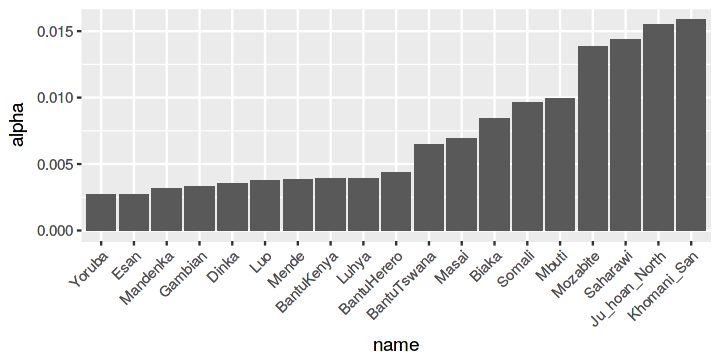

In [5]:
options(repr.plot.width=6, repr.plot.height=3)

inner_join(samples, direct_nea) %>% filter(pop == "Africa") %>% arrange(desc(alpha)) %>%
mutate(name=factor(name, levels=name[order(alpha)])) %>% 
ggplot(aes(name, alpha)) + geom_bar(stat="identity") + theme(axis.text.x=element_text(angle=45, hjust=1))

In [6]:
samples %<>% filter(!pop %in% c("Africa", "Oceania"))

# Calculating Nea ancestry using different ratios of f4 statistics

We used the data set containing the new Vindija sample:

In [102]:
EIGENSTRAT_DIR <- "../data/eigenstrat/bigyri_ho/"

EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "all")

SNP_FILE <- paste0(EIGENSTRAT_DIR, "all.snp")
GENO_FILE <- paste0(EIGENSTRAT_DIR, "all.geno")
IND_FILE <- paste0(EIGENSTRAT_DIR, "all.ind")

### Calculate the number of SNPs available for each sample on the 2.2M array

In [8]:
geno <- read_geno(GENO_FILE)
ind <- read_ind(IND_FILE)

snp_counts_f4 <- tibble(
    name=ind$label,
    snp_count=t(snps_present(geno))[, 1]
) %>% 
    group_by(name) %>%
    summarise(snp_count=as.integer(mean(snp_count)))

<br><br><br><br><br><br><br><br>
# Introduction
## A Tale of <del>Two</del> $N$ Neanderthal estimates, $N \in \{2, ..., \infty\}$


### Neanderthal estimates calculated on the archaic admixture array
![](img/decline_admixture_array.png)

Calculated simply as a proportion of alleles in an individual X that match a Neanderthal allele on biallelic sites at which:

* high-coverage Altai and Vindija genomes are homozygous for one allele,
* YRI population from 1000 GP phase I has a high frequency of the second allele (> 95%).

### Neanderthal estimates based on ratios of f4 statistics
![](img/decline_f4_ice_age.png)

Calculated on a combination of arrays, collectively called the 2.2M sites array:

![](img/2.2Marray.png)

Affymetrix Human Origins Array contains 11 different sets of SNPs, each ascertained on the basis of being heterozygous in a single genome sequence from each of the 11 different populations.

<br><br><br><br><br><br><br><br>
# Calculations of Nea ancestry estimate

## Nea. ancestry proportions using David's f4 ratio

![](img/mailund_f4_tree.png)

* A - West and Central Africans
* B - Dinka
* C - new_Altai + new_Vindija
* O - Chimp


![](img/ice_age_f4_description.png)

In [9]:
merge_pops(IND_FILE, paste0(IND_FILE, ".IceAge"),
           merge=list(West_and_Central_Africans=c("Yoruba", "Mbuti", "Mende"),
                      Archaics=c("new_Altai", "new_Denisova")))

In [10]:
iceage_Nea <- qpF4ratio(X=samples$name, A="West_and_Central_Africans", B="Archaics", C="Dinka", O="Chimp",
                        prefix=EIGENSTRAT, ind=paste0(IND_FILE, ".IceAge"))

In [11]:
iceage_Nea_alt <- qpF4ratio(X=samples$name, A="Mbuti", B="new_Vindija", C="Dinka", O="Chimp", prefix=EIGENSTRAT)

# Our new f4 ratio estimate

More straightforward & should be measuring what we _really_ want to measure:

![](img/mailund_f4_tree.png)

* A - new_Altai
* B - Vindija
* C - African
* O - Chimp

In [12]:
yoruba <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Yoruba", O="Chimp", prefix=EIGENSTRAT)
mbuti  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT)
mende  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mende", O="Chimp", prefix=EIGENSTRAT)
dinka  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Dinka", O="Chimp", prefix=EIGENSTRAT)

In [120]:
ty <- qpF4ratio(X=c(samples$name, "TY"), A="new_Altai", B="new_Vindija", C="Dinka", O="Chimp", prefix=EIGENSTRAT)

In [13]:
merge_pops(IND_FILE, paste0(IND_FILE, ".Africans"),
           merge=list(Africans=c("Yoruba", "Mbuti", "Mende", "Dinka")))

In [14]:
africans <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Africans", O="Chimp", prefix=EIGENSTRAT,
                      ind=paste0(IND_FILE, ".Africans"))

In [15]:
options(repr.plot.width=9, repr.plot.height=5)

### Merge all f4 results:

now this:

In [116]:
results <- bind_rows(
    inner_join(bind_rows(bind_rows(iceage_Nea, iceage_Nea_alt) %>% mutate(stat = "indirect_f4"),
                         bind_rows(mbuti,  yoruba, mende, dinka, africans) %>% mutate(stat = "direct_f4")),
               snp_counts_f4, by=c("X"="name")) %>% mutate(sites="all"),
    inner_join(direct_nea, snp_counts_direct) %>% rename(X=name) %>% mutate(sites = "admixture_array", stat = "admixture_prop")
) %>%
    inner_join(samples, by=c("X"="name")) %>%
    mutate(stderr=alpha / Zscore)

Joining, by = "name"


# Plot Nea. estimates over time

In [105]:
non_udg_samples <- c("AfontovaGora3", "Kotias", "Oase1", "Satsurblia", "Villabruna")

In [106]:
near_east <- c("BedouinB", "Druze", "Iranian", "Iraqi_Jew", "Jordanian",
               "Palestinian", "Samaritan", "Yemenite_Jew")

In [107]:
eur_nea <- filter(results, pop %in% c("EMH", "WestEurasia"),
                  !X %in% non_udg_samples,
                  !X %in% near_east)

## Results from the Ice Age paper

In [20]:
cutoff <- 200000

In [21]:
options(repr.plot.width=9, repr.plot.height=5)

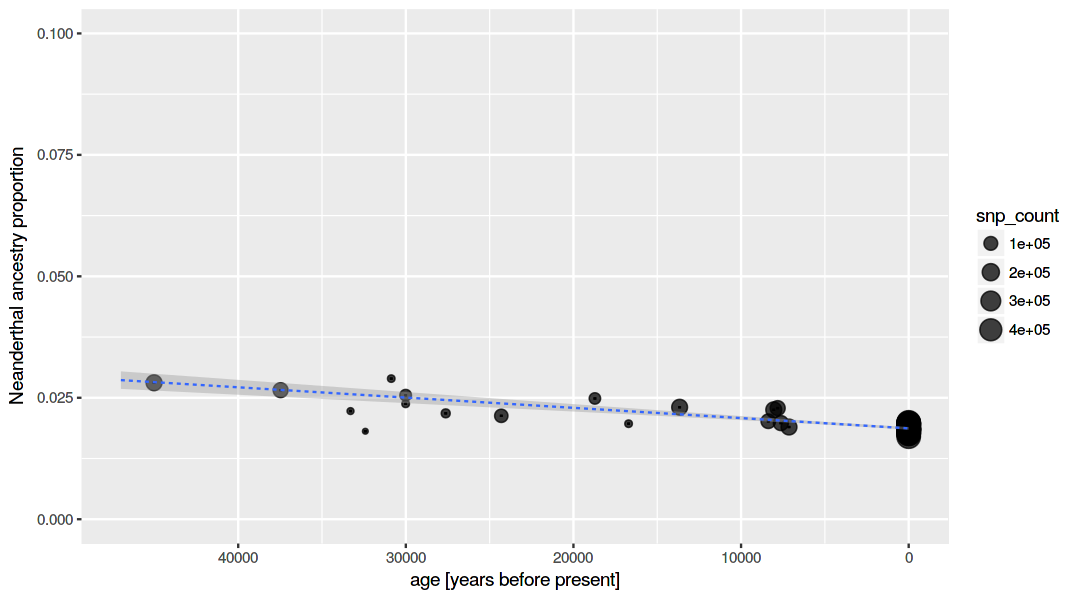

In [22]:
plot_nea_vs_time("direct", snp_cutoff = 2000)

Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

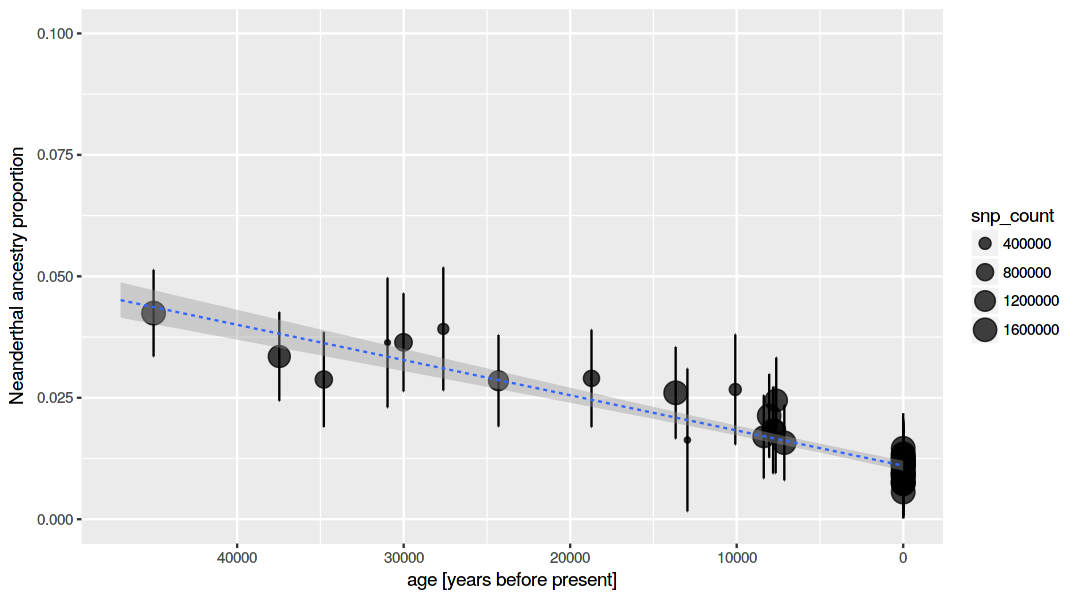

In [23]:
plot_nea_vs_time("qpF4ratio__West_and_Central_Africans_Archaics_Dinka_Chimp", ylim=c(0, 0.1), snp_cutoff=cutoff)

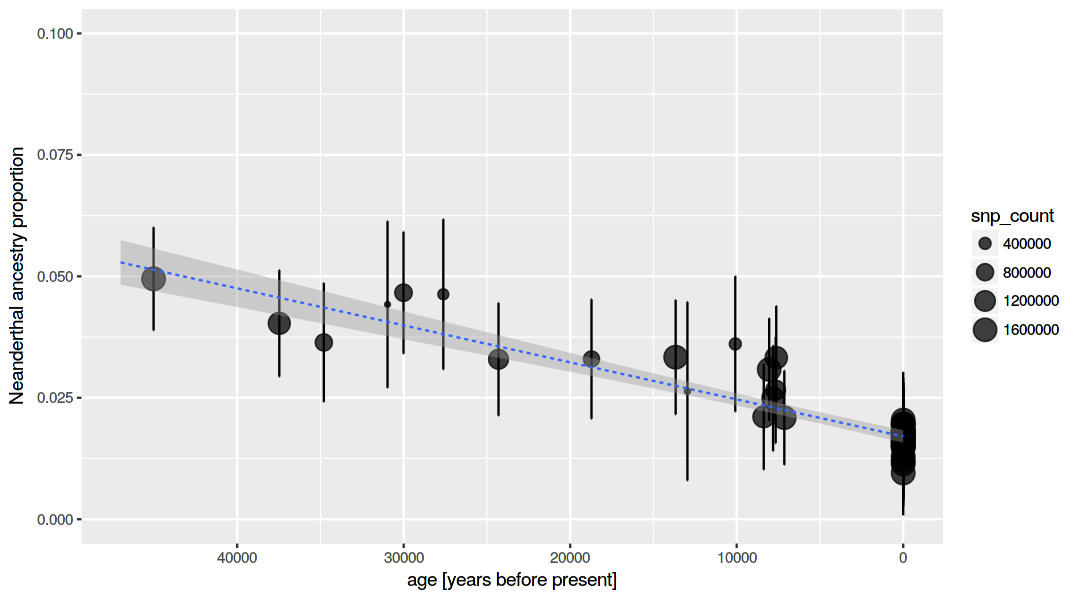

In [24]:
plot_nea_vs_time("qpF4ratio__Mbuti_new_Vindija_Dinka_Chimp", ylim=c(0, 0.1), snp_cutoff=cutoff)

# New f4 results

In [87]:
options(repr.plot.width=9, repr.plot.height=5)


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-8723043 -7040999 -5551628  3350934 49635215 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)     -4731      16372  -0.289    0.774
.[["alpha"]]   447103     719614   0.621    0.538

Residual standard error: 13310000 on 42 degrees of freedom
Multiple R-squared:  0.009107,	Adjusted R-squared:  -0.01449 
F-statistic: 0.386 on 1 and 42 DF,  p-value: 0.5378



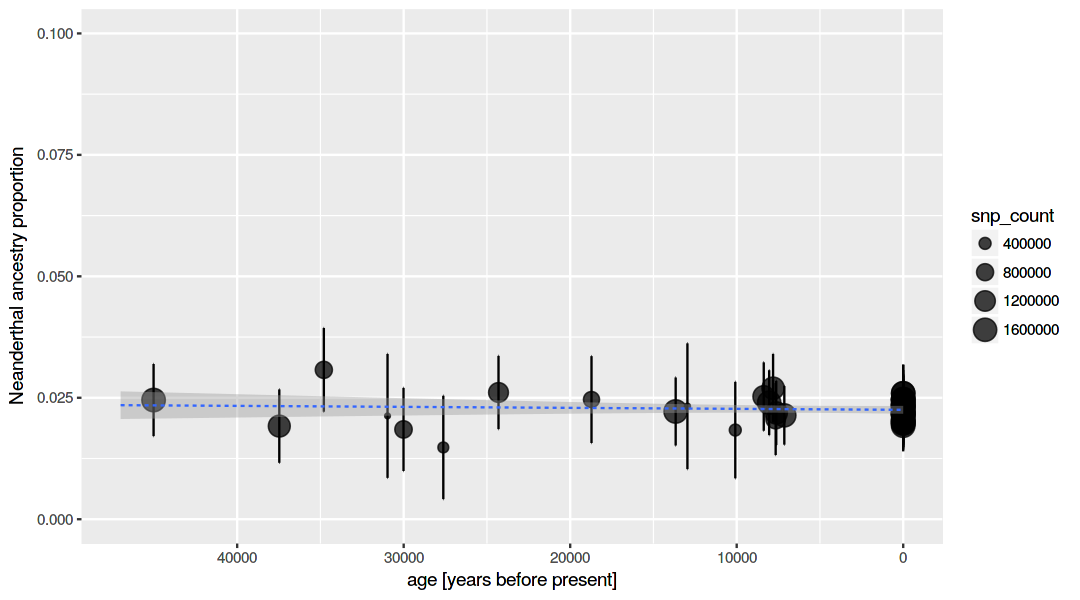

In [26]:
"qpF4ratio__new_Altai_new_Vindija_Africans_Chimp" %>% {
    run_lm(., snp_cutoff = cutoff) %>% summary %>% print
    plot_nea_vs_time(., snp_cutoff = cutoff)
}


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-7509217 -6940791 -6397363  3171466 50339762 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)      2130      14972   0.142    0.888
.[["alpha"]]   155597     710573   0.219    0.828

Residual standard error: 13360000 on 42 degrees of freedom
Multiple R-squared:  0.00114,	Adjusted R-squared:  -0.02264 
F-statistic: 0.04795 on 1 and 42 DF,  p-value: 0.8277



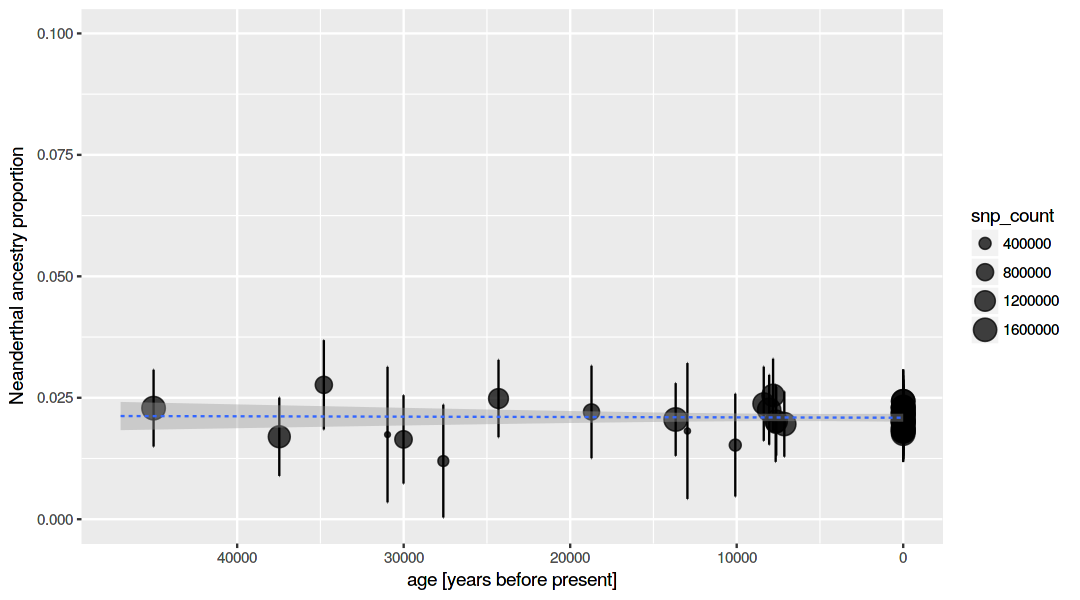

In [94]:
"qpF4ratio__new_Altai_new_Vindija_Mbuti_Chimp" %>% {
    run_lm(., snp_cutoff = cutoff) %>% summary %>% print
    plot_nea_vs_time(., snp_cutoff = cutoff)
}


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
      Min        1Q    Median        3Q       Max 
-10517986  -7062824  -4056450   3578126  48696280 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)    -15799      16162  -0.978    0.334
.[["alpha"]]   899070     682196   1.318    0.195

Residual standard error: 13100000 on 42 degrees of freedom
Multiple R-squared:  0.03971,	Adjusted R-squared:  0.01685 
F-statistic: 1.737 on 1 and 42 DF,  p-value: 0.1947



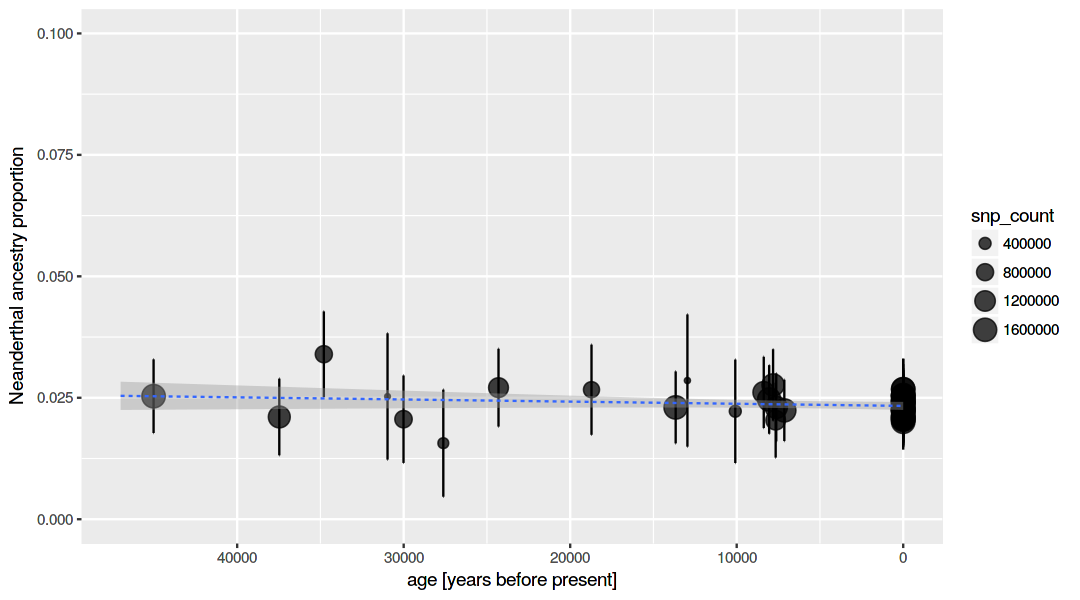

In [89]:
"qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp" %>% {
    run_lm(., snp_cutoff = cutoff) %>% summary %>% print
    plot_nea_vs_time(., snp_cutoff = cutoff)
}


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-7536374 -6954090 -6393221  3233621 50313839 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)      1450      17973   0.081    0.936
.[["alpha"]]   159404     724373   0.220    0.827

Residual standard error: 13360000 on 42 degrees of freedom
Multiple R-squared:  0.001152,	Adjusted R-squared:  -0.02263 
F-statistic: 0.04843 on 1 and 42 DF,  p-value: 0.8269



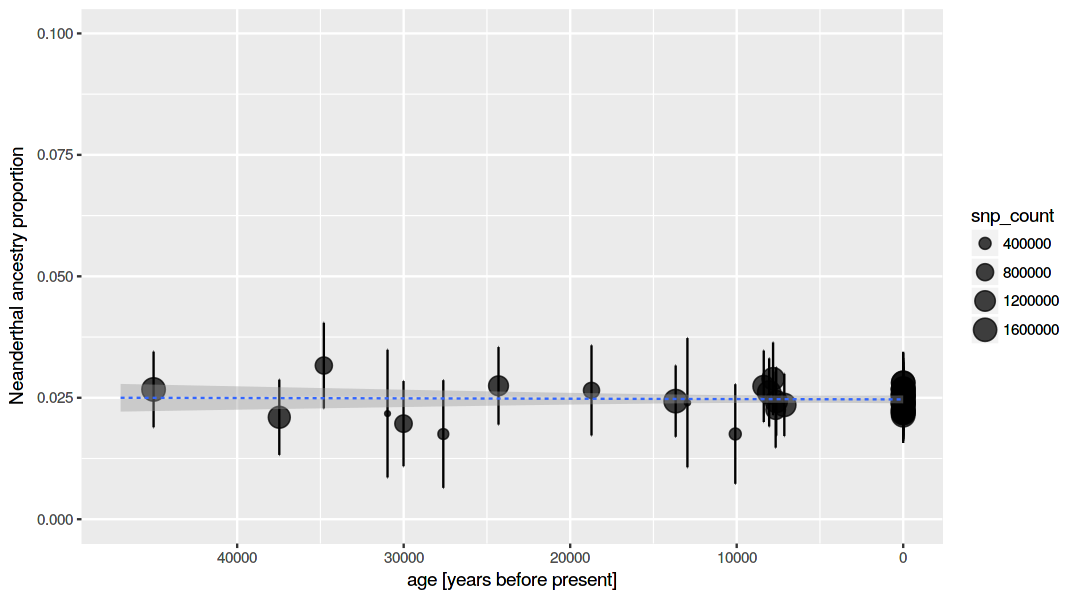

In [29]:
"qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp" %>% {
    run_lm(., snp_cutoff = cutoff) %>% summary %>% print
    plot_nea_vs_time(., snp_cutoff = cutoff)
}


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-9606211 -7068417 -4817923  3513379 49072222 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)     -9130      15365  -0.594    0.556
.[["alpha"]]   673155     708148   0.951    0.347

Residual standard error: 13230000 on 42 degrees of freedom
Multiple R-squared:  0.02106,	Adjusted R-squared:  -0.002247 
F-statistic: 0.9036 on 1 and 42 DF,  p-value: 0.3473



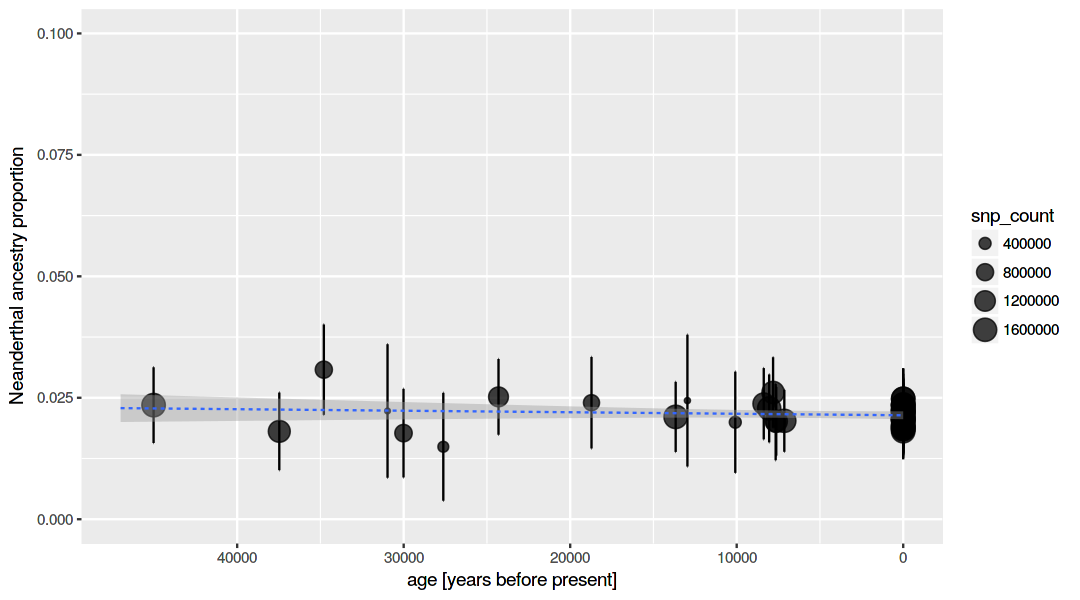

In [30]:
"qpF4ratio__new_Altai_new_Vindija_Mende_Chimp" %>% {
    run_lm(., snp_cutoff = cutoff) %>% summary %>% print
    plot_nea_vs_time(., snp_cutoff = cutoff)
}

# Write the admixture array estimates

In [31]:
eur_nea %>%
    filter(setup == "direct") %>%
    select(name=X, age, nea=alpha, pop, snp_count) %>%
    write_tsv("../data/admixture_array_nea.tsv")

In [32]:
results %>% select(-setup) %>% saveRDS("../paper/rds/nea_estimates.rds")